# Importance of Stop-loss

**Overview:** Algorithm basically has critical points that causes to place orders. There are three type of values:

1. Stop-loss price
2. Take-profit price
3. Re-buy price

All of the values is defined as the percentages of the entry price. For example; stop price may be 5% below of the entry price and re-buy price is below 10% of the entry price and take-profit price may be 10% of the entry price. Algorithm places order according to these critical values.

Algorithm will stop if the followings occur:

1. Take profit price hits,
2. After re-buy order placed, either of the stop or take profit price hits.

**Assumptions:**

- Every position opened/closed successfully.
- Capital is large enought to place all orders.
- Every position has the *same* volume.

**Testing:** Randomly select entry points for buy orders. Run simulation and plot the results. For analysis, test with different critical values and time.

# Program

## Parameters

In [1]:
STOP_PRICE_PERC     = -0.05                    # stop price percentage (should be negative)
TAKE_PROFIT_PERC    = +0.10                     # position will be closed if price rises TAKE_PROFIT_PERC%
REBUY_PERC          = STOP_PRICE_PERC - 0.03   # when the new buy order should be placed. (should be negative)
COMMISSION_FEE_PERC = 0.001                    # cost of every action

## Prepare Data

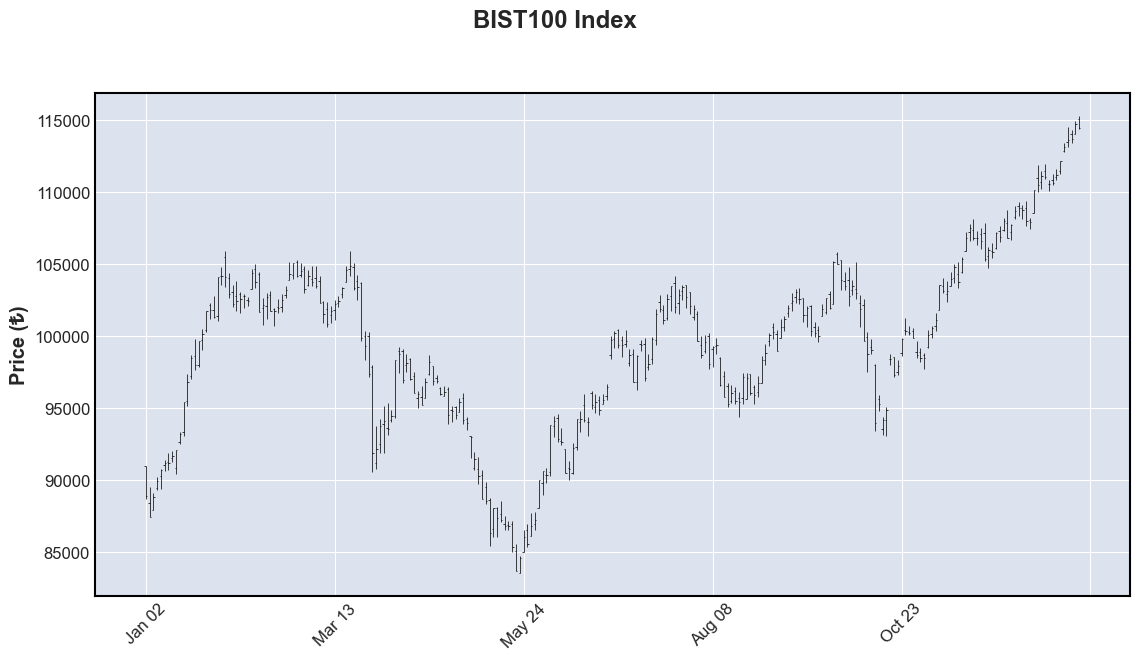

Total days: 248


In [2]:
# imports
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import mplfinance as mpf
import matplotlib.pyplot as plt
from datetime import datetime

# fetch data
begin_date = datetime(2019,1, 1)
end_date = datetime(2019, 12, 31)
data = web.DataReader('XU100.IS', 'yahoo', begin_date, end_date)

# plot data
mpf.plot(data, volume=False,
         figscale=1.25, figratio=(2,1), 
         title='BIST100 Index',
         ylabel='Price (₺)',
         ylabel_lower='Volume')
mpf.show()

print('Total days:', len(data.index))

## Algorithm (Position Class)

In [3]:
class Position():

    def __init__(self, data, entry_day_index):
        self.data = data
        self.entry_day_index = entry_day_index
        self.current_day_index = entry_day_index
        self.entry_price = data['Open'][entry_day_index]
        self.stop_price = self.entry_price * (1 + STOP_PRICE_PERC)
        self.take_profit_price = self.entry_price * (1 + TAKE_PROFIT_PERC)
        self.rebuy_price = self.entry_price * (1 + REBUY_PERC)
        self.profit = 0.0
        self.cost = self.entry_price * COMMISSION_FEE_PERC # commission
        self.status = 'open'
        self.log = f"Position opened on day #{self.entry_day_index} at {self.entry_price}\n"
    
    def update(self):
        if (self.status == 'closed') or (self.current_day_index + 1 >= len(self.data.index)):
            return
        self.current_day_index += 1
        current_price_high = self.data["High"][self.current_day_index]
        current_price_low = self.data["Low"][self.current_day_index]
        if self.status == 'triggered' or self.status == 'rebuyed':
            if self.status == 'rebuyed':
                if (self.take_profit_price <= current_price_high):
                    self.cost += self.take_profit_price * COMMISSION_FEE_PERC
                    self.status = 'closed'
                    self.profit += self.take_profit_price - self.rebuy_price
                    self.log += f"(R) Taking profit after {self.get_lifetime()} days at {self.take_profit_price} with profit of {self.profit}\n"
                if (self.stop_price >= current_price_low):
                    self.cost += self.stop_price * COMMISSION_FEE_PERC
                    self.status = 'closed'
                    self.profit += self.stop_price - self.rebuy_price
                    self.log += f"(R) Stop triggered after {self.get_lifetime()} days at {self.stop_price} with profit of {self.profit}\n"
            else:
                if (self.rebuy_price <= current_price_high):
                    self.cost += self.rebuy_price * COMMISSION_FEE_PERC
                    self.status = 'rebuyed'
                    self.stop_price = self.rebuy_price * (1 + STOP_PRICE_PERC)
                    self.take_profit_price = self.rebuy_price * (1 + TAKE_PROFIT_PERC)
                    self.log += f"Rebuying after {self.get_lifetime()} days at {self.rebuy_price}\n"
        else:
            if (self.take_profit_price <= current_price_high):
                self.cost += self.take_profit_price * COMMISSION_FEE_PERC
                self.status = 'closed'
                self.profit += self.take_profit_price - self.entry_price
                self.log += f"Taking profit after {self.get_lifetime()} days at {self.take_profit_price} with profit of {self.profit}\n"
            if (self.stop_price >= current_price_low):
                self.cost += self.stop_price * COMMISSION_FEE_PERC
                self.status = 'triggered'
                self.profit += self.stop_price - self.entry_price
                self.log += f"Stop triggered after {self.get_lifetime()} days at {self.stop_price} with profit of {self.profit}\n"

    def get_lifetime(self):
        return self.current_day_index - self.entry_day_index + 1

## Simulation

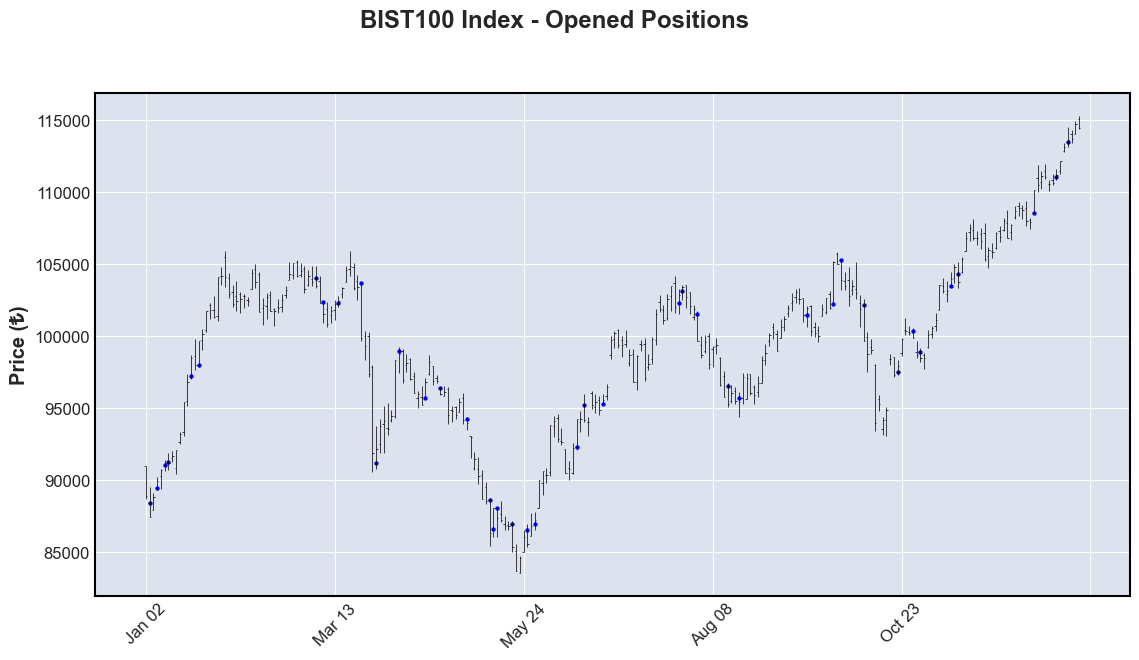

Randomly selected 41 days.


In [4]:
# select random days
day_indexes = np.random.default_rng().choice(len(data.index), size=len(data.index) // 6, replace=False)
day_indexes.sort()


# open positions
positions = [Position(data, day_index) for day_index in day_indexes]

# simulate
for day_index in range(len(data.index)):
    for position in positions:
        position.update()

# plot opened positions
l = []
for day in range(len(data.index)):
    if day in day_indexes:
        l.append(data['Open'][day])
    else:
        l.append(np.nan)
        
apd = mpf.make_addplot(l, type='scatter', color='b', marker='.')
mpf.plot(data, volume=False, addplot=apd,
         figscale=1.25, figratio=(2,1), 
         title='BIST100 Index - Opened Positions',
         ylabel='Price (₺)',
         ylabel_lower='Volume')
mpf.show()

print('Randomly selected', len(day_indexes), 'days.')

## Analize Results

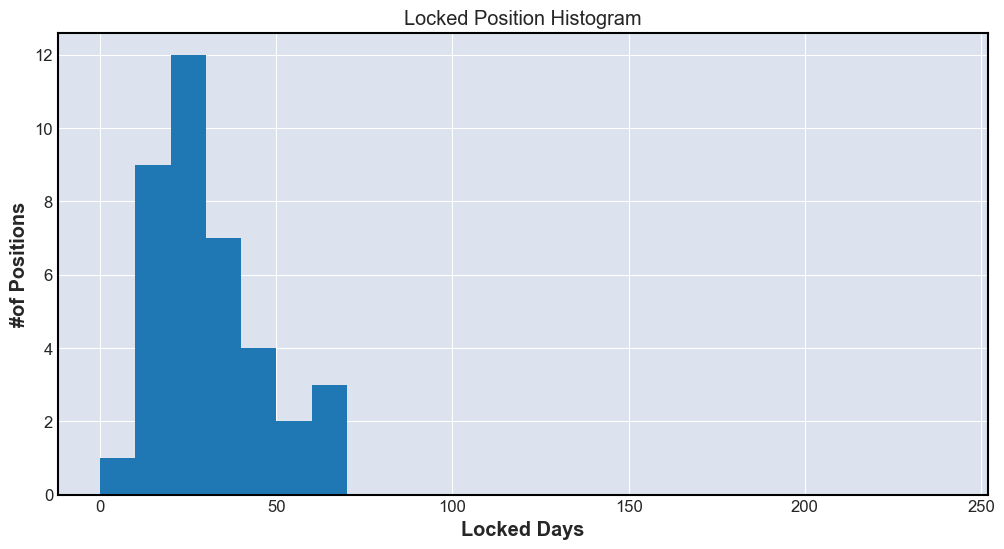

Total closed positions:            38
Unfinished position count:         3
Total profit percentage:           4.22%
Total profit percentage /w cost:   3.91%


In [5]:
total_wasted_money = 0.0
total_profit = 0.0
total_cost = 0.0
discarded_count = 0
locked_days = []


for position in positions:
    if position.status == 'triggered' or position.status == 'closed':
        total_wasted_money += position.entry_price
        if position.status == 'rebuyed':
            total_wasted_money += position.rebuy_price
        total_profit += position.profit
        total_cost += position.cost
        locked_days.append(position.get_lifetime())
    else:
        discarded_count += 1

plt.figure(figsize=(12,6))
plt.xlabel('Locked Days')
plt.ylabel('#of Positions')
plt.title('Locked Position Histogram')
plt.hist(locked_days, bins=range(0,len(data.index),10))
plt.show()
    
print("Total closed positions:           ", len(positions) - discarded_count)
print("Unfinished position count:        ", discarded_count)
print("Total profit percentage:          ", f"{round((total_profit / total_wasted_money) * 100, 2)}%")
print("Total profit percentage /w cost:  ", f"{round(((total_profit-total_cost) / (total_wasted_money+total_cost)) * 100, 2)}%")

## Log

In [6]:
for pos in positions:
    print(pos.log)

Position opened on day #1 at 88375.8984375
Taking profit after 11 days at 97213.48828125001 with profit of 8837.589843750015

Position opened on day #3 at 89444.703125
Taking profit after 10 days at 98389.17343750001 with profit of 8944.470312500009

Position opened on day #5 at 91031.6015625
Taking profit after 11 days at 100134.76171875001 with profit of 9103.160156250015

Position opened on day #6 at 91226.3984375
Taking profit after 10 days at 100349.03828125 with profit of 9122.639843750003

Position opened on day #12 at 97192.8984375
Stop triggered after 49 days at 92333.253515625 with profit of -4859.644921875006
Rebuying after 50 days at 89417.4665625
(R) Taking profit after 56 days at 98359.21321875001 with profit of 4082.101734374999

Position opened on day #14 at 97990.8984375
Stop triggered after 47 days at 93091.353515625 with profit of -4899.544921875
Rebuying after 48 days at 90151.62656250001
(R) Taking profit after 54 days at 99166.78921875001 with profit of 4115.61773

# Conclusion

TODO

Written by ***Berktuğ Kaan Özkan***.